<a href="https://colab.research.google.com/github/dnevo/Practicum/blob/master/S10_Integrated_Project_2_%E2%80%93_gold_concentration_in_mining_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Review (2)

Great update. Everything is correct now. So I'm accepting your project. Good luck with future learning.

---

## Review

Hi Doron. This is Soslan. As always I've added all my comments to new cells with different coloring.

<div class="alert alert-success" role="alert">
  If you did something great I'm using green color for my comment
</div>

<div class="alert alert-warning" role="alert">
If I want to give you advice or think that something can be improved, then I'll use yellow. This is an optional recommendation.
</div>

<div class="alert alert-danger" role="alert">
  If the topic requires some extra work so I can accept it then the color will be red
</div>

Although you did a nice project I can't accept it by the first iteration. I really like your code, charts, formatting. But you have to use cross-validation during training of your models. Can you please fix this so I can accept your project. Thanks.

---

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold  #added by reviewer

pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:11,.2f}'.format

# 1. Data Preparation
## 1.1 Open the files

In [2]:
train_data = pd.read_csv('https://raw.githubusercontent.com/dnevo/Practicum/master/datasets/gold_recovery_train.csv', index_col='date')
test_data = pd.read_csv('https://raw.githubusercontent.com/dnevo/Practicum/master/datasets/gold_recovery_test.csv', index_col='date')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                             

Train data contains 16,680 and 86 columns. All the columns have missing values

In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 non-null

Test data contains 5,856 rows and 52 columns. All the columns have missing values. 
<br>The data does not include the 2 Recovery columns.

Therefore we will retrieve these 2 columns from the Full data csv, and add to the Test dataframe:

In [5]:
full_data = pd.read_csv('https://raw.githubusercontent.com/dnevo/Practicum/master/datasets/gold_recovery_full.zip', header=0,
                        usecols=['date', 'rougher.output.recovery','final.output.recovery'], index_col='date')

In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   final.output.recovery    20753 non-null  float64
 1   rougher.output.recovery  19597 non-null  float64
dtypes: float64(2)
memory usage: 532.4+ KB


In [7]:
test_data = test_data.join(full_data)

<div class="alert alert-success" role="alert">
Good start
</div>

## 1.2 Validate that recovery is calculates correctly

$Recovery=\frac{C×(F-T)}{F×(C-T)}100$
Concentrate, Feed, Tail

In [8]:
def calc_recovery(C, F, T):
  return 100 * (C * (F-T)) / (F * (C-T))

recovery = train_data[[
                       'rougher.input.feed_au',
                       'rougher.output.concentrate_au',
                       'primary_cleaner.output.concentrate_au',
                       'final.output.concentrate_au',
                       'rougher.output.tail_au',
                       'primary_cleaner.output.tail_au',
                       'secondary_cleaner.output.tail_au',
                       'final.output.tail_au',
                       'rougher.output.recovery',
                       'final.output.recovery']].dropna(axis=0)
final_recovery = calc_recovery(
    recovery['final.output.concentrate_au'], recovery['rougher.input.feed_au'], recovery['final.output.tail_au'])
print('Predicted Final Recovery MAE: {:.15f}'.format(mean_absolute_error(recovery['final.output.recovery'], final_recovery)))
rougher_recovery = calc_recovery(
    recovery['rougher.output.concentrate_au'], recovery['rougher.input.feed_au'], recovery['rougher.output.tail_au'])
print('Predicted Rougher Recovery MAE: {:.15f}'.format(mean_absolute_error(recovery['rougher.output.recovery'], rougher_recovery)))

Predicted Final Recovery MAE: 0.000000000000009
Predicted Rougher Recovery MAE: 0.000000000000011


<div class="alert alert-success" role="alert">
Looks correct</div>

## 1.3 Features not available in the test set

In [9]:
print('Cols in Test:', set(test_data.columns))
cols_not_in_test = set(train_data.columns) - set(test_data.columns)
print('Cols not in Test:', cols_not_in_test)

Cols in Test: {'secondary_cleaner.state.floatbank6_a_level', 'secondary_cleaner.state.floatbank2_a_air', 'rougher.input.feed_sol', 'secondary_cleaner.state.floatbank4_a_air', 'rougher.input.floatbank11_xanthate', 'rougher.input.floatbank10_xanthate', 'primary_cleaner.input.feed_size', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.input.depressant', 'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank3_a_air', 'rougher.input.feed_size', 'final.output.recovery', 'rougher.state.floatbank10_f_air', 'secondary_cleaner.state.floatbank4_b_air', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_c_air', 'primary_cleaner.state.floatbank8_b_air', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_b_level', 'rougher.input.floatbank11_sulfate', 'rougher.state.floatbank10_a_air', 'rougher.input.feed_ag', 'rougher.state.floatbank10

As we see above, Test set includes all the features with `parameter_type` `state` and `input`, and does not include features with `parameter_type` `output` and `calculation`.

In [10]:
train_data[cols_not_in_test].describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
final.output.tail_au,"16,794.00",2.69,1.27,0.00,2.17,2.78,3.42,9.79
rougher.output.tail_pb,"16,778.00",0.60,0.33,0.00,0.41,0.59,0.78,3.78
rougher.output.tail_au,"14,611.00",1.76,0.73,0.02,1.31,1.75,2.19,9.69
rougher.output.tail_ag,"14,610.00",5.57,1.05,0.59,4.92,5.72,6.31,12.72
rougher.output.tail_sol,"14,611.00",17.87,3.46,10.01,15.65,18.00,19.93,66.12
rougher.calculation.floatbank10_sulfate_to_au_feed,"16,833.00","3,784.84","70,887.20","-2,023,458.74","2,502.31","2,854.64","3,644.41","6,211,432.53"
rougher.calculation.au_pb_ratio,"15,618.00",2.33,0.90,-0.01,1.98,2.23,2.64,39.38
rougher.output.concentrate_sol,"16,698.00",25.39,10.40,0.00,24.79,28.80,31.54,40.09
final.output.concentrate_pb,"16,788.00",9.11,3.39,0.00,8.83,10.07,11.05,17.03
final.output.tail_pb,"16,677.00",2.36,1.22,0.00,1.64,2.45,3.19,6.09


As above:
- features with `parameter_type`=`output` represent percentages (0 - 100)
- features with `parameter_type`=`calculation` represents ratios

## 1.4 Data pre-processing

In [11]:
train_data.describe().transpose().sort_index()

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,"16,788.00",4.72,2.10,0.00,3.97,4.87,5.82,16.00
final.output.concentrate_au,"16,789.00",39.47,13.92,0.00,42.06,44.50,45.98,53.61
final.output.concentrate_pb,"16,788.00",9.11,3.39,0.00,8.83,10.07,11.05,17.03
final.output.concentrate_sol,"16,490.00",8.30,3.83,0.00,6.94,8.56,10.29,18.12
final.output.recovery,"15,339.00",67.21,11.96,0.00,62.63,67.64,72.82,100.00
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,"16,775.00",-500.23,76.98,-799.74,-500.53,-499.78,-496.53,-275.07
secondary_cleaner.state.floatbank5_b_air,"16,775.00",12.38,6.22,0.43,8.93,11.09,15.98,39.85
secondary_cleaner.state.floatbank5_b_level,"16,776.00",-498.96,82.15,-800.26,-500.15,-499.93,-498.42,-120.19
secondary_cleaner.state.floatbank6_a_air,"16,757.00",18.43,6.96,0.02,13.98,18.03,24.98,54.88


### Note: we will handle missing data and anomalies later

<div class="alert alert-danger" role="alert">
    <s>What about missed values? You have a hint in project about how to handle them.</s></div>

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.

`fillna()` with `method = 'ffill'` can helps. But before it is better to clean rows with missed values in target.

---


<div class="alert alert-success" role="alert">
Fixed</div>

# 2. Data Analysis
## 2.1 Concetrations of metals per purification stage

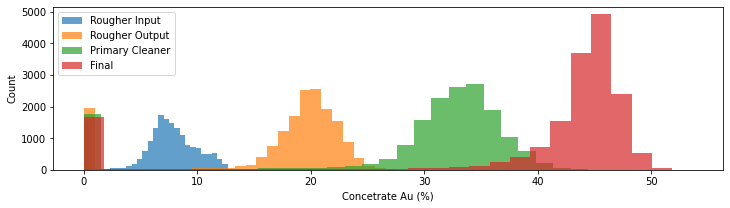

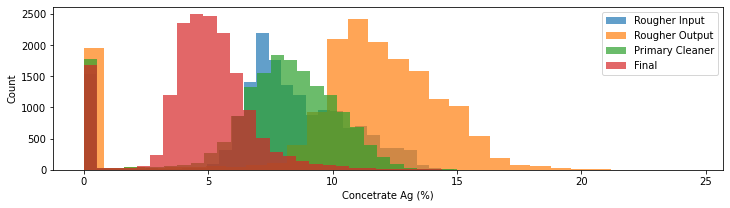

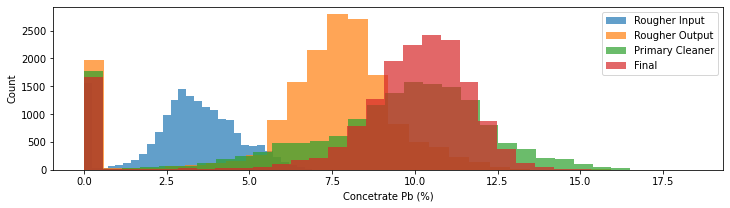

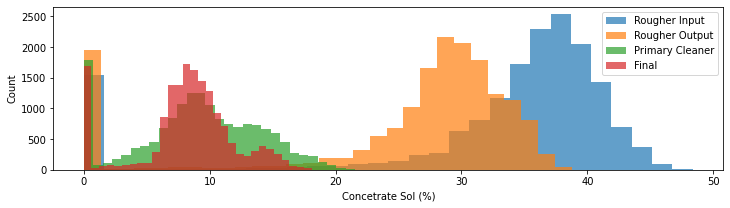

In [12]:
def kdeplot_concentrate(data, metal):
  nbins = 30
  plt.figure(figsize=(12, 3))
  sns.distplot(data[f'rougher.input.feed_{metal.lower()}'], hist = True, kde=False, bins=nbins, label='Rougher Input',hist_kws={'alpha':0.7})  
  sns.distplot(data[f'rougher.output.concentrate_{metal.lower()}'], hist = True, kde=False, bins=nbins, label='Rougher Output',hist_kws={'alpha':0.7})  
  sns.distplot(data[f'primary_cleaner.output.concentrate_{metal.lower()}'], hist = True, kde=False, bins=nbins, label='Primary Cleaner',hist_kws={'alpha':0.7})  
  sns.distplot(data[f'final.output.concentrate_{metal.lower()}'], hist = True, kde=False, bins=nbins, label='Final',hist_kws={'alpha':0.7})
  plt.legend()
  plt.xlabel(f'Concetrate {metal} (%)');
  plt.ylabel('Count')
  plt.show()

for metal in ['Au', 'Ag','Pb','Sol']:
  kdeplot_concentrate(train_data, metal)

<div class="alert alert-success" role="alert">
Nice charts</div>

As can be noted above, there are many (>1000) abnormal values which are close to zero.

In [13]:
print('Final recovery=0%:', len(train_data[(train_data['final.output.recovery'] == 0)]))
print('Final recovery=100%:', len(train_data[(train_data['final.output.recovery'] == 100)]))
print('Final recovery=NaN:', len(train_data[(train_data['final.output.recovery'].isna())]))
print('Rougher recovery=0%:', len(train_data[(train_data['rougher.output.recovery'] == 0)]))
print('Rougher recovery=NaN:', len(train_data[(train_data['rougher.output.recovery'].isna())]))

Final recovery=0%: 89
Final recovery=100%: 473
Final recovery=NaN: 1521
Rougher recovery=0%: 320
Rougher recovery=NaN: 2573


As above most anomalies cases (>1500) are when Final / Rougher Recovery are NaN. We should drop them from both train and test sets since it is not a good practice play around with values of the result columns. 
In addition, it will fix most of the abnormal concetration around zero, as in the plots above.

In [14]:
train_data.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)
test_data.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

We will drop also the rows the rows with total input concentrations equal to zero, as they are measurement errors

In [15]:
train_data = train_data[
                        train_data['rougher.input.feed_au'] + train_data['rougher.input.feed_ag'] 
                        + train_data['rougher.input.feed_pb'] + train_data['rougher.input.feed_sol'] > 0]
test_data = test_data[
                        test_data['rougher.input.feed_au'] + test_data['rougher.input.feed_ag'] 
                        + test_data['rougher.input.feed_pb'] + test_data['rougher.input.feed_sol'] > 0]

We will fill the missing values in both Train and test sets:

In [16]:
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

## 2.2 Comparison of feed particle size distribution in training and test sets

Text(0, 0.5, 'Probability Density')

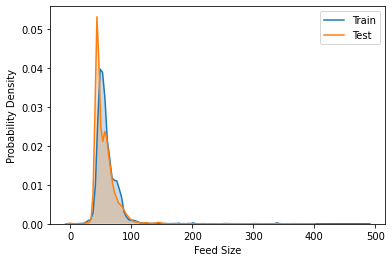

In [17]:
sns.kdeplot(train_data['rougher.input.feed_size'], shade=True, Label='Train')  
sns.kdeplot(test_data['rougher.input.feed_size'], shade=True, Label='Test')  
plt.xlabel('Feed Size');
plt.ylabel('Probability Density')

In [18]:
print(train_data['rougher.input.feed_size'].describe())
print(test_data['rougher.input.feed_size'].describe())

count     13,976.00
mean          59.47
std           23.10
min            0.00
25%           48.79
50%           55.18
75%           65.79
max          484.97
Name: rougher.input.feed_size, dtype: float64
count      5,269.00
mean          55.96
std           19.11
min            0.00
25%           43.91
50%           50.86
75%           62.46
max          392.49
Name: rougher.input.feed_size, dtype: float64


As can be noted above, the distributions are similar.

## 2.3. Total concentrations of all substances per stage

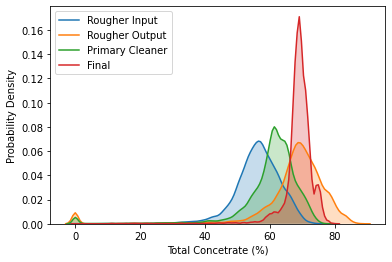

In [19]:
train_data['rougher_input_all'] = train_data['rougher.input.feed_au'] + train_data['rougher.input.feed_ag'] + train_data['rougher.input.feed_pb'] + train_data['rougher.input.feed_sol']
train_data['rougher_output_all'] = train_data['rougher.output.concentrate_au'] + train_data['rougher.output.concentrate_ag'] + train_data['rougher.output.concentrate_pb'] + train_data['rougher.output.concentrate_sol']
train_data['primary_cleaner_output_all'] = train_data['primary_cleaner.output.concentrate_au'] + train_data['primary_cleaner.output.concentrate_ag'] + train_data['primary_cleaner.output.concentrate_pb'] + train_data['primary_cleaner.output.concentrate_sol']
train_data['final_output_all'] = train_data['final.output.concentrate_au'] + train_data['final.output.concentrate_ag'] + train_data['final.output.concentrate_pb'] + train_data['final.output.concentrate_sol']

sns.kdeplot(train_data['rougher_input_all'], shade=True, Label='Rougher Input')
sns.kdeplot(train_data['rougher_output_all'], shade=True, Label='Rougher Output')
sns.kdeplot(train_data['primary_cleaner_output_all'], shade=True, Label='Primary Cleaner')
sns.kdeplot(train_data['final_output_all'], shade=True, Label='Final')
plt.xlabel('Total Concetrate (%)');
plt.ylabel('Probability Density')
plt.legend()
plt.show()

As can be noted in the plots, we can nicely notice that as we progress in the stages from Rougher input towards Final, the average concentrate increases and the distribution gets denser.

<div class="alert alert-warning" role="alert">
By the task description I think you can delete anomalies as probably they are errors of appliances.
</div>

Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

---

# 3. Building the model
## 3.1 Preparations

### Function to calculate the Final SMAPE
Evaluation metric is sMAPE (symmetric Mean Absolute Percentage Error).

It is similar to MAE, but is expressed in relative values instead of absolute ones. Why is it symmetrical? It equally takes into account the scale of both the target and the prediction.

In [20]:
def smape(Y, Yp):
    return 100/len(Yp) * np.sum(2 * np.abs(Yp - Y) / (np.abs(Y) + np.abs(Yp)))

def calc_metrics(set_features, set_targets):
    set_predictions = model.predict(set_features)
    rougher_smape = smape(set_targets.iloc[:,0], set_predictions[:,0])
    final_output_smape = smape(set_targets.iloc[:,1], set_predictions[:,1])
    final_smape = 0.25*rougher_smape + 0.75*final_output_smape
    return final_smape

<div class="alert alert-success" role="alert">
Correct function. I think Jupiter notebook prefers Tab or 4 spaces. That is why some keywords in your functions are red.</div>

### Function to plot Validation Curve

In [21]:
def validation_curve(train_scores, valid_scores, param_range):
    plt.figure(figsize=(9, 6))
    plt.plot(param_range, train_scores, 'o-', color="r", label="Training")
    plt.plot(param_range, valid_scores, 'o-', color="b", label="Validation")
    plt.ylabel('Score') 
    plt.title('Validation Curve')
    plt.legend()
    plt.grid()
    plt.show()

### Preparation for Cross-Validation: replace `date` index by integer index - because Kfold assumes integer index:

In [22]:
train_data.reset_index(drop=True,inplace=True)
target = train_data[['rougher.output.recovery','final.output.recovery']]
features = train_data[list(test_data.columns)].drop(['rougher.output.recovery','final.output.recovery'], axis=1)

### Function to calculate averaged SMAPE with Cross Validation

In [23]:
def cross_val_smape(model):
    train_scores, valid_scores = [], []
    kf = KFold(n_splits=3, random_state=12345)
    for train, valid in kf.split(features):
        model.fit(features.iloc[train], target.iloc[train])
        train_scores.append(calc_metrics(features.iloc[train], target.iloc[train]))
        valid_scores.append(calc_metrics(features.iloc[valid], target.iloc[valid]))
    return np.mean(train_scores), np.mean(valid_scores)

<div class="alert alert-warning" role="alert">
You have forgotten to include KFold, did it instead of you to avoid another iteration.</div>

## 3.2 Model training

### Linear Regression Model

In [24]:
model = LinearRegression() 
mean_train_score, mean_valid_score = cross_val_smape(model)
print('Train Final SMAPE: {:.2f}'.format(mean_train_score))
print('Valid Final SMAPE: {:.2f}'.format(mean_valid_score))

Train Final SMAPE: 8.88
Valid Final SMAPE: 15.27


In [25]:
### Decision Tree Model

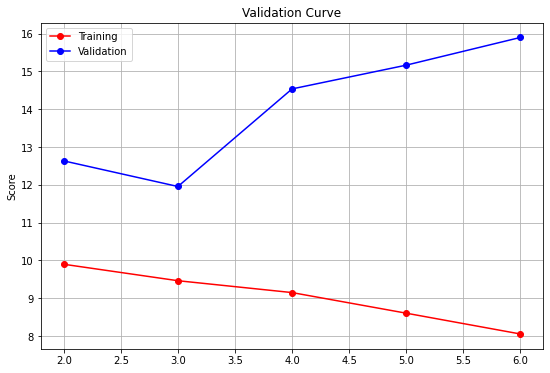

In [26]:
train_scores = []
valid_scores = []
param_range = []
for depth in range(2,7):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    mean_train_score, mean_valid_score = cross_val_smape(model)
    train_scores.append(mean_train_score)
    valid_scores.append(mean_valid_score)
    param_range.append(depth)
validation_curve(train_scores, valid_scores, param_range)

Best value: max_depth = 3

<div class="alert alert-success" role="alert">
Nice charts</div>

### Random Forest Model

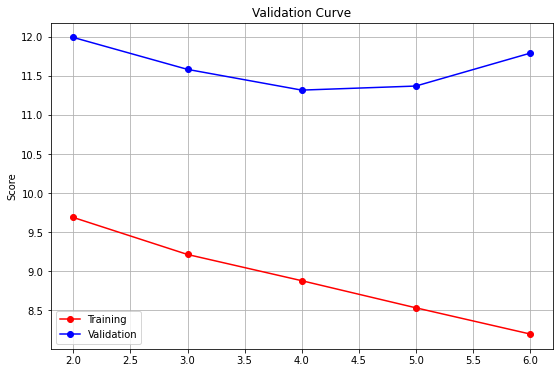

In [27]:
train_scores = []
valid_scores = []
param_range = []
for depth in range(2,7):
    model = RandomForestRegressor(random_state=12345, max_depth=depth)
    mean_train_score, mean_valid_score = cross_val_smape(model)
    train_scores.append(mean_train_score)
    valid_scores.append(mean_valid_score)
    param_range.append(depth)
validation_curve(train_scores, valid_scores, param_range)

best value: max_depth = 4. Let's check n_estimators:

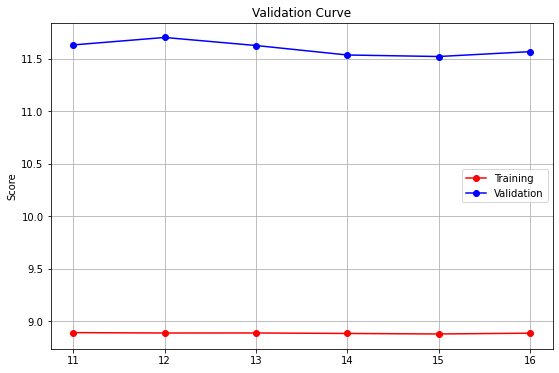

In [28]:
train_scores = []
valid_scores = []
param_range = []
for n_estim in range(11,17):
    model = RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=n_estim) 
    mean_train_score, mean_valid_score = cross_val_smape(model)
    train_scores.append(mean_train_score)
    valid_scores.append(mean_valid_score)
    param_range.append(n_estim)
validation_curve(train_scores, valid_scores, param_range)

Best value: n_estimators = 14

<div class="alert alert-danger" role="alert">
<s>Although you did everything correctly I have to ask you to use cross-validation for hyperparameter search as this is the requirement of the project.</s></div>

<div class="alert alert-success" role="alert">
Fixed</div>

Citation: 3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

---

# Conclusion (and the winner is...)

The best model in this case is Random Forest. Lets calculate the metrics:

In [29]:
target_test = test_data[['rougher.output.recovery','final.output.recovery']]
features_test = test_data.drop(['rougher.output.recovery','final.output.recovery'], axis=1)

model = RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=14) 
model.fit(features, target)
print('Test Final SMAPE: {:.2f}'.format(calc_metrics(features_test, target_test)))

Test Final SMAPE: 9.24


<div class="alert alert-warning" role="alert">
    <s>You can also try the best Random Forest as Decision Tree tends to overfit easily.</s></div>
    
  <div class="alert alert-success" role="alert">
Final result looks better now.</div>